In [1]:
import fastai.collab as fc
import fastai.tabular.all as ft
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

# Exploratory Data Analysis

https://www.kaggle.com/marlesson/myanimelist-dataset-animes-profiles-reviews

In [1]:
#!unzip archive.zip

Archive:  archive.zip
  inflating: animes.csv              
  inflating: profiles.csv            
  inflating: reviews.csv             


In [5]:
animes = pd.read_csv("animes.csv")

In [6]:
users = pd.read_csv("profiles.csv")

In [7]:
ratings = pd.read_csv("reviews.csv")

In [8]:
animes.columns

Index(['uid', 'title', 'synopsis', 'genre', 'aired', 'episodes', 'members',
       'popularity', 'ranked', 'score', 'img_url', 'link'],
      dtype='object')

In [10]:
users.columns

Index(['profile', 'gender', 'birthday', 'favorites_anime', 'link'], dtype='object')

In [11]:
ratings.columns

Index(['uid', 'profile', 'anime_uid', 'text', 'score', 'scores', 'link'], dtype='object')

## Usando Solo los Ratings

In [14]:
ratings = ratings[['uid', 'anime_uid', 'score']]

In [16]:
ratings.head()

,uid,anime_uid,score
0,255938,34096,8
1,259117,34599,10
2,253664,28891,7
3,8254,2904,9
4,291149,4181,10


In [18]:
dls = fc.CollabDataLoaders.from_df(ratings,
                                   user_name = 'uid',
                                   item_name='anime_uid',
                                   rating_name='score',
                                   bs=128)

In [19]:
def flat_l1(yp, y):
    return F.l1_loss(yp.view(-1), y.view(-1))
#La métrica l1 nos sirve más para ver a qué distancia del valor 
#verdadero estamos predicendo

#Además, ajustamos las dimensiones de salida

In [20]:
learn = fc.collab_learner(dls,
                          opt_fun=ft.ranger, 
                          metrics = flat_l1)

In [21]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(114060, 50)
  (i_weight): Embedding(7727, 50)
  (u_bias): Embedding(114060, 1)
  (i_bias): Embedding(7727, 1)
)

- *u_weigth* es el peso de los usuarios
- *i_weigth* es el peso de los items(animes)


In [22]:
learn.summary()

EmbeddingDotBias (Input shape: ['128 x 2'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            128 x 50             5,703,000  True      
________________________________________________________________
Embedding            128 x 50             386,350    True      
________________________________________________________________
Embedding            128 x 1              114,060    True      
________________________________________________________________
Embedding            128 x 1              7,727      True      
________________________________________________________________

Total params: 6,211,137
Total trainable params: 6,211,137
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7f59df00d6a8>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.9120108485221863)

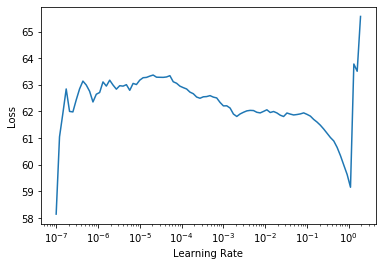

In [23]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,11.124458,10.493403,2.484524,00:16
1,6.345027,10.292260,2.444273,00:16
2,4.862785,9.826722,2.384931,00:16
3,4.936876,9.440171,2.324989,00:16
4,4.822859,9.233997,2.281089,00:16
5,4.830420,9.265440,2.280852,00:16
6,4.724238,9.049484,2.251114,00:16
7,4.503029,9.079191,2.253416,00:16
8,4.412022,9.105468,2.248553,00:16
9,4.667058,9.130526,2.254016,00:16


EL error significa que si el usuario vota a un 5, el sistema tiene una desviación de 1.73 unidades

## Mejorando el modelo

In [28]:
learn = fc.collab_learner(dls, 
                          opt_function=fc.ranger,
                          n_factors=8, #Bajando el número de categorías
                          metrics = flat_l1)

In [30]:
learn.fit_one_cycle(15, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,10.790444,10.312512,2.427287,00:13
1,5.179253,7.776936,2.052295,00:13
2,2.982771,7.430416,2.012713,00:13
3,2.532609,7.305079,1.998714,00:13
4,2.405651,7.148126,1.959595,00:13
5,2.363402,7.183987,1.965980,00:13
6,2.249950,7.040498,1.930144,00:13
7,2.257828,7.126473,1.943480,00:13
8,2.277412,7.041726,1.925053,00:13
9,2.241772,7.125996,1.940116,00:13


El modelo mejoró un poco, en menos épocas.

### Hasta ahora, las predicciones habían sido hechas multiplicando los pesos de los usuarios con los pesos de los items y sumando los bias.

users,items = x[:,0],x[:,1]
        dot = self.u_weight(users)* self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()

In [31]:
learn.model??

Signature:      learn.model(n_factors, n_users, n_items, y_range=None)
Call signature: learn.model(*input, **kwargs)
Type:           EmbeddingDotBias
String form:   
EmbeddingDotBias(
  (u_weight): Embedding(114060, 8)
  (i_weight): Embedding(7727, 8)
  (u_bias): Embedding(114060, 1)
  (i_bias): Embedding(7727, 1)
)
File:           /usr/local/lib/python3.6/dist-packages/fastai/collab.py
Source:        
class EmbeddingDotBias(Module):
    "Base dot model for collaborative filtering."
    def __init__(self, n_factors, n_users, n_items, y_range=None):
        self.y_range = y_range
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [Embedding(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, x):
        users,items = x[:,0],x[:,1]
        dot = self.u_weight(users)* self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_rang

### Como ya tenemos los embedings del usuario y de los items, usaremos una red neuronal ara predecir los scores

In [47]:
learn = fc.collab_learner(dls,
                         opt_function= fc.ranger,
                         use_nn=True,
                         n_factors=8,
                         emb_szs={'uid':8,'anime_uid':16},
                          #Analizar los datos para seleccionar el tamaño
                         metrics=flat_l1,
                         layers=[256]
                          #Podemos hacer la red más profunda. No es 
                          #Obligatorio poner layers de más
                         )

In [48]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(114060, 8)
    (1): Embedding(7727, 16)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=24, out_features=256, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.009120108559727669)

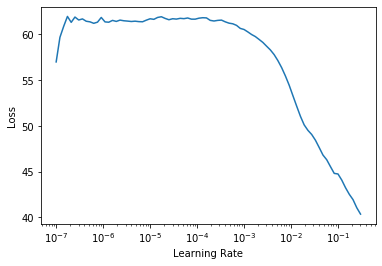

In [49]:
learn.lr_find()

In [50]:
learn.fit_one_cycle(15, 3e-2,div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,3.263683,3.049342,1.294904,00:15
1,1.410930,2.889720,1.281685,00:15
2,0.957442,2.690839,1.181615,00:15
3,0.841739,2.664074,1.193160,00:15
4,0.861669,2.638426,1.167289,00:15
5,0.844988,2.784548,1.250382,00:15
6,0.862092,2.693314,1.207324,00:16
7,0.833252,2.676901,1.179360,00:15
8,0.881388,2.689453,1.159620,00:15
9,0.902369,2.728348,1.159864,00:15


Optimizamos el sigma en casi la mitad.

## Hasta este momento, esto es lo mejor que podemos hacer sólo con los ratings. Podemos usar las demás cracterísticas de lso csv y uniro en una tabla, para poder trabajar con tabularpandas

# Trabajando con todos los csv y sus características

## Ingeniería de atributos: Limpiando los csv

In [2]:
pd.set_option('display.max_columns', None)

Para que no haya los ... al mostrar el dataset

### Ratings

In [3]:
#ratings = pd.read_csv("reviews.csv")

In [4]:
ratings.head(3)

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n \n \n \n \n more pics \n \n \n \n \n \n Overall \n 8 \n \n \n Story \n 8 \n \n \n Animation \n 8 \n \n \n Sound \n 10 \n \n \n Character \n 9 \n \n \n Enjoyment \n 8 \n \n \n \n\n \n First things firs...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8', 'Sound': '10', 'Character': '9', 'Enjoyment': '8'}",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n \n \n \n \n more pics \n \n \n \n \n \n Overall \n 10 \n \n \n Story \n 10 \n \n \n Animation \n 10 \n \n \n Sound \n 10 \n \n \n Character \n 10 \n \n \n Enjoyment \n 10 \n \n \n \n\n \n Let me start...,10,"{'Overall': '10', 'Story': '10', 'Animation': '10', 'Sound': '10', 'Character': '10', 'Enjoyment': '10'}",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n \n \n \n \n more pics \n \n \n \n \n \n Overall \n 7 \n \n \n Story \n 7 \n \n \n Animation \n 9 \n \n \n Sound \n 8 \n \n \n Character \n 8 \n \n \n Enjoyment \n 8 \n \n \n \n\n \n Art 9/10: It is gr...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9', 'Sound': '8', 'Character': '8', 'Enjoyment': '8'}",https://myanimelist.net/reviews.php?id=253664


In [5]:
to_delete_ratings=['text', #No hacemos procesamiento de lenguaje
                   'link', 
                   'scores', 
                   'profile']# No nos sirve saber el nombre del perfil del votante
ratings = ratings.drop(to_delete_ratings, axis=1)
ratings.head()

,uid,anime_uid,score
0,255938,34096,8
1,259117,34599,10
2,253664,28891,7
3,8254,2904,9
4,291149,4181,10


### Users

In [83]:
#users = pd.read_csv("profiles.csv")

In [84]:
users.head(3)

,profile,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '269', '18245', '2904', '27899', '17074', '12291', '226', '28851', '8525', '6594', '4981', '1698', '457', '235', '34618']",https://myanimelist.net/profile/DesolatePsyche
1,baekbeans,Female,"Nov 10, 2000","['11061', '31964', '853', '20583', '918', '9253', '34599', '3588', '13601', '6956']",https://myanimelist.net/profile/baekbeans
2,skrn,NaN,NaN,"['918', '2904', '11741', '17074', '23273', '32281', '9989', '1943', '512']",https://myanimelist.net/profile/skrn


In [85]:
to_delete_users=['profile', 'link']
users = users.drop(to_delete_users, axis=1)
users.head(3)

,gender,birthday,favorites_anime
0,Male,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '269', '18245', '2904', '27899', '17074', '12291', '226', '28851', '8525', '6594', '4981', '1698', '457', '235', '34618']"
1,Female,"Nov 10, 2000","['11061', '31964', '853', '20583', '918', '9253', '34599', '3588', '13601', '6956']"
2,NaN,NaN,"['918', '2904', '11741', '17074', '23273', '32281', '9989', '1943', '512']"


#### Calculando la edad

Los datos son del 05/01/20:

In [86]:
def get_age(x):
    try:
        if(type(x) != 'float'):
            _, year = x.split(",")
            return 2020-int(year)
    except:
        return None
#get_age("Oct 2, 1994")

In [87]:
age_ = users.birthday.apply(get_age)

In [88]:
len(age_)==len(users)

True

Ya que yengo la edad, voy a agregar esa serie y borrar la de birthday

In [89]:
users.head(2)

,gender,birthday,favorites_anime
0,Male,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '269', '18245', '2904', '27899', '17074', '12291', '226', '28851', '8525', '6594', '4981', '1698', '457', '235', '34618']"
1,Female,"Nov 10, 2000","['11061', '31964', '853', '20583', '918', '9253', '34599', '3588', '13601', '6956']"


In [90]:
users.drop('birthday', axis =1, inplace=True)
users['age']=age_

In [91]:
users.head(2)

,gender,favorites_anime,age
0,Male,"['33352', '25013', '5530', '33674', '1482', '269', '18245', '2904', '27899', '17074', '12291', '226', '28851', '8525', '6594', '4981', '1698', '457', '235', '34618']",26.0
1,Female,"['11061', '31964', '853', '20583', '918', '9253', '34599', '3588', '13601', '6956']",20.0


### Animes

In [16]:
#animes = pd.read_csv("animes.csv")
animes.head(2)

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,"Following their participation at the Inter-High, the Karasuno High School volleyball team attempts to refocus their efforts, aiming to conquer the Spring tournament instead. \r\n \r\nWhen they receive an invitation from long-standing rival Nekoma High, Karasuno agrees to take part in a large training camp alongside many notable volleyball teams in Tokyo and even some national level players. By playing with some of the toughest teams in Japan, they hope not only to sharpen their skills, but also come up with new attacks that would strengthen them. Moreover, Hinata and Kageyama attempt to d...","['Comedy', 'Sports', 'Drama', 'School', 'Shounen']","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/76662.jpg,https://myanimelist.net/anime/28891/Haikyuu_Second_Season
1,23273,Shigatsu wa Kimi no Uso,"Music accompanies the path of the human metronome, the prodigious pianist Kousei Arima. But after the passing of his mother, Saki Arima, Kousei falls into a downward spiral, rendering him unable to hear the sound of his own piano. \r\n \r\nTwo years later, Kousei still avoids the piano, leaving behind his admirers and rivals, and lives a colorless life alongside his friends Tsubaki Sawabe and Ryouta Watari. However, everything changes when he meets a beautiful violinist, Kaori Miyazono, who stirs up his world and sets him on a journey to face music again. \r\n \r\nBased on the manga serie...","['Drama', 'Music', 'Romance', 'School', 'Shounen']","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/67177.jpg,https://myanimelist.net/anime/23273/Shigatsu_wa_Kimi_no_Uso


In [17]:
animes.drop(['synopsis','aired','img_url','link'],axis=1,inplace=True)

In [18]:
animes.head(2)

,uid,title,genre,episodes,members,popularity,ranked,score
0,28891,Haikyuu!! Second Season,"['Comedy', 'Sports', 'Drama', 'School', 'Shounen']",25.0,489888,141,25.0,8.82
1,23273,Shigatsu wa Kimi no Uso,"['Drama', 'Music', 'Romance', 'School', 'Shounen']",22.0,995473,28,24.0,8.83


## Ahora que ya están limpios los datos, hay que encodear los géneros en *animes*

In [19]:
animes.genre.head(1).unique

<bound method Series.unique of 0    ['Comedy', 'Sports', 'Drama', 'School', 'Shounen']
Name: genre, dtype: object>

In [23]:
generos_df = []
def obtener_generos(x):
    global generos_df
    try:
        #print("x: \t",x)
        generos_x = [ gen for gen in x.lstrip("[").rstrip("]").split(",") ]
        #print("gen",generos_x, type(generos_x))
        for genero in generos_x:
            genero = genero.strip()
            if genero not in generos_df:
                #print(genero)
                generos_df.append(genero)
        #return(generos_df)
    except:
        #print("ex")
        return None

### Ya jala, pero regresa una sola lista. Voy a modificarla para regresar una columna de géros y hacer get_dummies

In [324]:
"""generos_to_dummies = pd.DataSeries()
def obtener_generos_para_serie(x):
    global generos_to_dummies
#try:
    
    generos_x = [ gen.strip() for gen in x.lstrip("[").rstrip("]").split(",") ]
    print("gen",generos_x, type(generos_x))
    for genero in generos_x:
        #genero = genero.strip()
        print (genero)
        generos_to_dummies.append([genero], ignore_index=True )
    return (generos_to_dummies)
    #return(generos_df)
#except:
    #print("ex")
 #   return None
"""
#En esta parte quise hacer que por cada fila, sacara los géneros de la columna genre 
# y los pusiera en una nueva fila de otra serie, para después unir la serie nueva al dataframe  animes
# Con esto poder hacer get_dummies

##¿Me pueden ayudar a hacerlo?

'generos_to_dummies = pd.DataSeries()\ndef obtener_generos_para_serie(x):\n    global generos_to_dummies\n#try:\n    \n    generos_x = [ gen.strip() for gen in x.lstrip("[").rstrip("]").split(",") ]\n    print("gen",generos_x, type(generos_x))\n    for genero in generos_x:\n        #genero = genero.strip()\n        print (genero)\n        generos_to_dummies.append([genero], ignore_index=True )\n    return (generos_to_dummies)\n    #return(generos_df)\n#except:\n    #print("ex")\n #   return None\n'

In [24]:
animes.genre.apply(obtener_generos)
#animes.genre.head(1).apply(obtener_generos_para_serie)

0        None
1        None
2        None
3        None
4        None
         ... 
19306    None
19307    None
19308    None
19309    None
19310    None
Name: genre, Length: 19311, dtype: object

In [321]:
#generos_to_dummies

""


In [25]:
generos_df

["'Comedy'",
 "'Sports'",
 "'Drama'",
 "'School'",
 "'Shounen'",
 "'Music'",
 "'Romance'",
 "'Sci-Fi'",
 "'Adventure'",
 "'Mystery'",
 "'Fantasy'",
 "'Action'",
 "'Military'",
 "'Magic'",
 "'Supernatural'",
 "'Vampire'",
 "'Slice of Life'",
 "'Demons'",
 "'Historical'",
 "'Super Power'",
 "'Mecha'",
 "'Parody'",
 "'Samurai'",
 "'Seinen'",
 "'Police'",
 "'Psychological'",
 "'Josei'",
 "'Space'",
 "'Kids'",
 "'Shoujo Ai'",
 "'Ecchi'",
 "'Shoujo'",
 "'Horror'",
 "'Shounen Ai'",
 "'Cars'",
 "'Martial Arts'",
 "'Game'",
 "'Thriller'",
 "'Dementia'",
 "'Harem'",
 '',
 "'Hentai'",
 "'Yaoi'",
 "'Yuri'"]

### Ahora ya tenemos los géneros. Procedo a poner los valores como columnas y marcar de qué genero son los ánimes

In [26]:
animes_generos = animes.join (pd.DataFrame(columns=generos_df, index = animes.index))
animes_generos.head(2)

,uid,title,genre,episodes,members,popularity,ranked,score,'Comedy','Sports','Drama','School','Shounen','Music','Romance','Sci-Fi','Adventure','Mystery','Fantasy','Action','Military','Magic','Supernatural','Vampire','Slice of Life','Demons','Historical','Super Power','Mecha','Parody','Samurai','Seinen','Police','Psychological','Josei','Space','Kids','Shoujo Ai','Ecchi','Shoujo','Horror','Shounen Ai','Cars','Martial Arts','Game','Thriller','Dementia','Harem',,'Hentai','Yaoi','Yuri'
0,28891,Haikyuu!! Second Season,"['Comedy', 'Sports', 'Drama', 'School', 'Shounen']",25.0,489888,141,25.0,8.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23273,Shigatsu wa Kimi no Uso,"['Drama', 'Music', 'Romance', 'School', 'Shounen']",22.0,995473,28,24.0,8.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
print(animes.iloc[0]['genre'])

['Comedy', 'Sports', 'Drama', 'School', 'Shounen']


In [67]:
def clasificar_generos(x): 
    #global animes
    ##print(animes.iloc[x])
    #print(animes_generos.iloc[x]['genre'])
    try:
        #print("x: \t",x)
        #print(animes.iloc[0])
        generos_x = [ gen.strip() for gen in animes.iloc[x]['genre'].lstrip("[").rstrip("]").split(",") ]
        #print("gen",generos_x, type(generos_x))
        for genero in generos_x:
            if genero in animes_generos.columns:
                #print(genero)
                #print(animes_generos.iloc[x][genero])
                animes_generos.loc[x, genero] = 1

        #return(generos_df)
    except:
        print("ex")
        return 0

In [71]:
#animes.genre.head(1).apply(clasificar_generos)
animes.index.to_series().apply(clasificar_generos)

0        None
1        None
2        None
3        None
4        None
         ... 
19306    None
19307    None
19308    None
19309    None
19310    None
Length: 19311, dtype: object

In [69]:
#animes_generos.columns

In [72]:
animes_generos.tail(4)

,uid,title,genre,episodes,members,popularity,ranked,score,'Comedy','Sports','Drama','School','Shounen','Music','Romance','Sci-Fi','Adventure','Mystery','Fantasy','Action','Military','Magic','Supernatural','Vampire','Slice of Life','Demons','Historical','Super Power','Mecha','Parody','Samurai','Seinen','Police','Psychological','Josei','Space','Kids','Shoujo Ai','Ecchi','Shoujo','Horror','Shounen Ai','Cars','Martial Arts','Game','Thriller','Dementia','Harem',,'Hentai','Yaoi','Yuri'
19307,123,Fushigi Yuugi,"['Adventure', 'Fantasy', 'Magic', 'Martial Arts', 'Comedy', 'Romance', 'Historical', 'Drama', 'Shoujo']",52.0,84407,1292,1071.0,7.73,1,NaN,1,NaN,NaN,NaN,1,NaN,1,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19308,1281,Gakkou no Kaidan,"['Mystery', 'Horror', 'Supernatural']",19.0,83093,1314,1073.0,7.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19309,450,InuYasha Movie 2: Kagami no Naka no Mugenjo,"['Action', 'Adventure', 'Comedy', 'Historical', 'Demons', 'Supernatural', 'Drama', 'Magic', 'Romance', 'Fantasy', 'Shounen']",1.0,71989,1469,1077.0,7.73,1,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,1,NaN,1,1,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19310,87,Mobile Suit Gundam: Char's Counterattack,"['Military', 'Sci-Fi', 'Space', 'Drama', 'Mecha']",1.0,29248,2604,1081.0,7.73,NaN,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
animes_generos.drop('genre',axis=1, inplace = True)
animes_generos.fillna(0,inplace=True)

In [78]:
animes_generos.head(3)

,uid,title,episodes,members,popularity,ranked,score,'Comedy','Sports','Drama','School','Shounen','Music','Romance','Sci-Fi','Adventure','Mystery','Fantasy','Action','Military','Magic','Supernatural','Vampire','Slice of Life','Demons','Historical','Super Power','Mecha','Parody','Samurai','Seinen','Police','Psychological','Josei','Space','Kids','Shoujo Ai','Ecchi','Shoujo','Horror','Shounen Ai','Cars','Martial Arts','Game','Thriller','Dementia','Harem',,'Hentai','Yaoi','Yuri'
0,28891,Haikyuu!! Second Season,25.0,489888,141,25.0,8.82,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,23273,Shigatsu wa Kimi no Uso,22.0,995473,28,24.0,8.83,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,34599,Made in Abyss,13.0,581663,98,23.0,8.83,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
animes_generos.head(1)

,uid,title,episodes,members,popularity,ranked,score,'Comedy','Sports','Drama','School','Shounen','Music','Romance','Sci-Fi','Adventure','Mystery','Fantasy','Action','Military','Magic','Supernatural','Vampire','Slice of Life','Demons','Historical','Super Power','Mecha','Parody','Samurai','Seinen','Police','Psychological','Josei','Space','Kids','Shoujo Ai','Ecchi','Shoujo','Horror','Shounen Ai','Cars','Martial Arts','Game','Thriller','Dementia','Harem',,'Hentai','Yaoi','Yuri'
0,28891,Haikyuu!! Second Season,25.0,489888,141,25.0,8.82,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [93]:
users.head(1)

,gender,favorites_anime,age
0,Male,"['33352', '25013', '5530', '33674', '1482', '269', '18245', '2904', '27899', '17074', '12291', '226', '28851', '8525', '6594', '4981', '1698', '457', '235', '34618']",26.0


In [94]:
ratings.head(1)

,uid,anime_uid,score
0,255938,34096,8
